In [1]:
library(dplyr)
library(ggplot2)
library(RcppRoll)
library(sqldf)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: gsubfn

Loading required package: proto

Warning message in doTryCatch(return(expr), name, parentenv, handler):
“unable to load shared object '/Library/Frameworks/R.framework/Resources/modules//R_X11.so':
  dlopen(/Library/Frameworks/R.framework/Resources/modules//R_X11.so, 6): Library not loaded: /opt/X11/lib/libSM.6.dylib
  Referenced from: /Library/Frameworks/R.framework/Versions/3.6/Resources/modules/R_X11.so
  Reason: image not found”
Could not load tcltk.  Will use slower R code instead.

Loading required package: RSQLite



In [2]:
# to get this data:
# git clone https://github.com/chadwickbureau/retrosplits

df = read.csv('data/retrosplits/daybyday/playing-1999.csv')
df$season = 1999

for (season_ in 1999:2019)
{
    filename = paste0('data/retrosplits/daybyday/playing-', as.character(season_), '.csv')
    df_new = read.csv(filename)
    df_new$season = season_
    df = rbind(df, df_new)

}

In [3]:
# we later define "expected woba" using previous and following seasons' woba. 
# exclude players without a previous and next season (rookies, retirees)
# use inner join this onto the game-level data once "expected woba" is calculated and added to the dataset
player_years = df %>% select(person.key, season) %>% mutate(next_year = season+1, previous_year=season-1) %>% distinct()
player_years_to_keep = player_years %>% inner_join(player_years, by=c("season"="previous_year", "person.key"="person.key"))
player_years_to_keep = player_years_to_keep %>% inner_join(player_years, by=c("season"="next_year", "person.key"="person.key"))

In [4]:
# limit to just regular season, define 1B events
df = df %>% filter(season.phase=='R')
df = df %>% mutate(B_1B = B_H - B_2B - B_3B - B_HR)

In [5]:
# define game number within the season. later we'll want to exclude the final five games from streak identification
game_nums = df %>% group_by(season, team.key) %>% distinct(game.date, game.key, team.key) %>% arrange(season, team.key, game.date) %>% 
    mutate(game_num = seq_along(game.date))

df = df %>% left_join(game_nums %>% ungroup() %>% select(game.key, team.key, game_num), by=c('game.key', 'team.key'))

# do this filter AFTER creating game numbers so the game number is still accurate
df = df %>% filter(team.key != 'COL', site.key != 'DEN02')

In [6]:
# create home/away flag by finding most common stadium for each team
home_stadiums = df %>% group_by(team.key, season) %>% count(site.key) %>% top_n(1)
df = df %>% left_join(home_stadiums, by=c('team.key', 'season'), 
                 suffix=c('', '_homeflag')) %>% 
    mutate(home_or_away = ifelse(site.key==site.key_homeflag, 'home', 'away'))

Selecting by n



In [7]:
df = df %>% mutate(game.date = as.Date(game.date))

# Hot/cold streak definition

* Defined a hot / cold wOBA threshold 
* Rolling wOBA over five-game periods (so first or last five of the year cant be considered)
* Must have at least 20 PA in the five game stretch to be considered
* Thresholds defined as groups where 5 percent of league is hot, 5 is cold for a given 5 game stretch
* Roughly this means .525 woba for hot, .195 for cold 



TODO: make sure streaks don't count if a player missed a game in the middle. 

In [8]:
# define woba numerator and denominator to get N-game woba
# weights by year https://www.fangraphs.com/guts.aspx?type=cn
df = df %>% mutate(
    woba_numerator = 0.9*B_1B + 1.24*B_2B + 1.56*B_3B + 1.95*B_HR + 0.72*(B_BB - B_IBB) + 0.75*B_HP +  0.92*B_XI, # the book's weights
    woba_denominator = B_PA,
    game_woba = woba_numerator / woba_denominator)

In [9]:
# SQL query to create players' expected woba
# expected woba: a player's woba from the current, previous, and following season, omitting the player's past 5 games (inclusive of the current game)
player_woba = sqldf('
      select 
        df1."person.key",
        df1.season,
        df1.game_num,
        SUM(coalesce(df2.woba_numerator, 0)) season_woba_num,
        SUM(coalesce(df2.woba_denominator, 0)) season_woba_denom,
        sum(coalesce(df2.woba_numerator, 0))/sum(coalesce(df2.woba_denominator, 0)) expected_woba,
        sum(df2.B_PA) season_pa
      from
        df AS df1
      left join
        (select "person.key", season, game_num, SUM(coalesce(woba_numerator, 0)) woba_numerator,
    SUM(coalesce(woba_denominator, 0)) woba_denominator, sum(B_PA) B_PA from df group by 1,2,3) AS df2
      ON
        df1."person.key" = df2."person.key"
      AND
        df1.season <= df2.season + 1
      AND
        df1.season >= df2.season - 1
      AND
        (
            (df1.season*1000 + df1.game_num) <= (df2.season*1000 + df2.game_num -7)
        OR
            (df1.season*1000 + df1.game_num) > (df2.season*1000 + df2.game_num)
        )
      GROUP BY df1."person.key", df1.season, df1.game_num
')

In [10]:
player_woba %>% filter(season_pa>50) %>% arrange(-expected_woba) %>% head(15)

,person.key,season,game_num,season_woba_num,season_woba_denom,expected_woba,season_pa
,<fct>,<dbl>,<int>,<dbl>,<int>,<dbl>,<int>
1,strad001,1999,153,112.44,204,0.5511765,204
2,strad001,1999,154,100.96,188,0.5370213,188
3,strad001,1999,144,111.64,212,0.5266038,212
4,strad001,1999,152,112.44,216,0.5205556,216
5,strad001,1999,156,103.04,200,0.5152000,200
6,strad001,1999,157,106.64,208,0.5126923,208
7,strad001,1999,148,110.32,220,0.5014545,220
8,strad001,1999,146,105.92,212,0.4996226,212
9,strad001,1999,151,101.76,204,0.4988235,204


In [11]:
df = df %>% left_join(player_woba,by=c('season', 'person.key', 'game_num'))

# remove these seasons. no future/past season available for calculating their expected woba values
df = df %>% filter(season > 1999, season < 2019)

dim(df)
# remove players we can't calculate an expected woba for 
df = df %>% inner_join(player_years_to_keep, by=c("person.key", "season"), suffixes=c("", "_ignore"))
dim(df)

[1] 1251409     188

[1] 1008701     194

In [12]:
# take rolling sums of woba components to get a 5g woba
library(zoo)
num_games_streak = 5
num_games_post_streak = 5
min_pa_in_streak = 4 * num_games_streak #4
min_pa_post_streak = 3 * num_games_post_streak #0
# different offset used for post streak folling counts for 3 vs. 5 game configuration. paste this in if changing streak lenghts.
seven_game_post = list(c(1, 2, 3,4,5,6,7))
five_game_post = list(c(1, 2, 3, 4, 5))

# this is ugly indentation but makes it ahrder to forget to paste something when updating it
df = df %>%
         arrange(season, person.key, game.date, game.key) %>%
         group_by(season, person.key) %>%
         mutate(woba_num_rolling =   roll_sum(woba_numerator, num_games_streak, align = "right", fill = NA),
                pa_rolling =         roll_sum(B_PA, num_games_streak, align = "right", fill = NA),
                woba_denom_rolling = roll_sum(woba_denominator, num_games_streak, align = "right", fill = NA),
                woba_rolling = woba_num_rolling/woba_denom_rolling,
                woba_num_rolling_future =   rollapply(woba_numerator, FUN=sum, five_game_post, align = "left", fill = NA),
                pa_rolling_future =         rollapply(B_PA, FUN=sum, five_game_post, align = "left", fill = NA),
                woba_denom_rolling_future = rollapply(woba_denominator, FUN=sum,  five_game_post, align = "left", fill = NA),
                woba_rolling_future = woba_num_rolling_future/woba_denom_rolling_future,
                
                woba_num_rolling_future_nextgame =   rollapply(woba_numerator, FUN=sum, list(c(1)), align = "left", fill = NA),
                woba_denom_rolling_future_nextgame  = rollapply(woba_denominator, FUN=sum,  list(c(1)), align = "left", fill = NA),
                woba_rolling_future_nextgame  = woba_num_rolling_future_nextgame /woba_denom_rolling_future_nextgame 
        ) 


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric




## Get Thresholds for Hot/Cold Streaks (top/bottom 5% of league in x-game rolling wOBA)

In [13]:
# get seasons' percentiles for woba thresholds
df %>% 
    # only consider periods with at least 20 pa in them 
    filter(pa_rolling >= min_pa_in_streak, pa_rolling_future >= min_pa_post_streak) %>% 
    group_by(season, person.key, game.key) %>% summarise(woba = sum(woba_numerator) / sum(woba_denominator),
                                                  #woba_rolling_avg = mean(woba_rolling, na.rm=TRUE), 
                                                  woba_rolling_avg = sum(woba_num_rolling, na.rm=TRUE)/sum(woba_denom_rolling, na.rm=TRUE),
                                                  pa = sum(B_PA)) %>%
    ungroup() %>%
    summarise(thresholds = quantile(woba_rolling_avg, probs = c(0.05, 0.95))) 

`summarise()` regrouping output by 'season', 'person.key' (override with `.groups` argument)



thresholds
<dbl>
0.168
0.544


In [14]:
# create is hot/cold flags
hot_threshold = .544 
cold_threshold = .168
df = df %>% ungroup() %>% 
    mutate(is_hot = ifelse(((woba_rolling > hot_threshold) & (pa_rolling>=min_pa_in_streak) & (game_num < 157)), 1, 0),
           is_cold = ifelse(((woba_rolling < cold_threshold) & (pa_rolling>=min_pa_in_streak) & (game_num < 157)), 1, 0))

## Calculate Streak, Post-Streak, and Expected Value Summary Stats

In [15]:
df %>% ungroup() %>%
    filter(is_hot==1,
          !is.na(woba_rolling_future)) %>%
    mutate(weighted_woba_num=B_PA*season_woba_num,
          weighted_woba_denom=B_PA*season_woba_denom) %>%
    summarise(
        unique_hot_players = n_distinct(person.key),
        total_hot_streaks = sum(is_hot),
        total_hot_pa = sum(pa_rolling),
        mean_hot_woba = sum(woba_num_rolling, na.rm=TRUE)/sum(woba_denom_rolling, na.rm=TRUE),
        mean_post_hot_woba_nextgame = sum(woba_num_rolling_future_nextgame, na.rm=TRUE)/sum(woba_denom_rolling_future_nextgame, na.rm=TRUE),
        mean_post_hot_woba = sum(woba_num_rolling_future, na.rm=TRUE)/sum(woba_denom_rolling_future, na.rm=TRUE),
        expected_woba= mean(expected_woba, na.rm=TRUE),
        std_mean_post_hot_woba = 1.96 * (sd(woba_num_rolling_future/woba_denom_rolling_future, na.rm=TRUE) / sqrt(n())),
        upper_ci_post = mean_post_hot_woba + std_mean_post_hot_woba,
        lower_ci_post = mean_post_hot_woba - std_mean_post_hot_woba,
        mean_season_woba = sum(season_woba_num) / sum(season_woba_denom)
    )

df %>% ungroup() %>%
    filter(is_cold==1,
          !is.na(woba_rolling_future)) %>%
    mutate(weighted_woba_num=B_PA*season_woba_num,
          weighted_woba_denom=B_PA*season_woba_denom) %>%
    summarise(
        unique_hot_players = n_distinct(person.key),
        total_hot_streaks = sum(is_cold),
        total_hot_pa = sum(pa_rolling),
        mean_hot_woba = sum(woba_num_rolling, na.rm=TRUE)/sum(woba_denom_rolling, na.rm=TRUE),
        mean_post_hot_woba_nextgame = sum(woba_num_rolling_future_nextgame, na.rm=TRUE)/sum(woba_denom_rolling_future_nextgame, na.rm=TRUE),
        mean_post_hot_woba = sum(woba_num_rolling_future, na.rm=TRUE)/sum(woba_denom_rolling_future, na.rm=TRUE),
        expected_woba= mean(expected_woba, na.rm=TRUE),
        std_mean_post_hot_woba = 1.96 * (sd(woba_num_rolling_future/woba_denom_rolling_future, na.rm=TRUE) / sqrt(n())),
        upper_ci_post = mean_post_hot_woba + std_mean_post_hot_woba,
        lower_ci_post = mean_post_hot_woba - std_mean_post_hot_woba,
        mean_season_woba = sum(season_woba_num) / sum(season_woba_denom)
    )


unique_hot_players,total_hot_streaks,total_hot_pa,mean_hot_woba,mean_post_hot_woba_nextgame,mean_post_hot_woba,expected_woba,std_mean_post_hot_woba,upper_ci_post,lower_ci_post,mean_season_woba
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
943,18562,409073,0.601861,0.3551308,0.354568,0.3554687,0.001755279,0.3563233,0.3528128,0.3593545


unique_hot_players,total_hot_streaks,total_hot_pa,mean_hot_woba,mean_post_hot_woba_nextgame,mean_post_hot_woba,expected_woba,std_mean_post_hot_woba,upper_ci_post,lower_ci_post,mean_season_woba
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1116,19265,412469,0.1298019,0.3250169,0.3265349,0.325296,0.001678122,0.328213,0.3248567,0.3296723


In [16]:
# table of example streaks for the blog post
df %>% ungroup() %>%
    filter(is_hot==1,
           season==2018,
          !is.na(woba_rolling_future)) %>%
    select(person.key, game.date, pa_rolling, woba_rolling, woba_rolling_future, expected_woba) %>% 
    arrange(-woba_rolling) %>% head(10)

# table of example streaks for the blog post
df %>% ungroup() %>%
    filter(is_cold==1,
           season==2018,
          !is.na(woba_rolling_future)) %>%
    select(person.key, game.date, pa_rolling, woba_rolling, woba_rolling_future, expected_woba) %>% 
    arrange(woba_rolling) %>% head(10)

person.key,game.date,pa_rolling,woba_rolling,woba_rolling_future,expected_woba
<fct>,<date>,<dbl>,<dbl>,<dbl>,<dbl>
carpm002,2018-07-21,20,0.8800000,0.2440000,0.3549653
ramij003,2018-07-14,20,0.8255000,0.4933333,0.3753247
carpm002,2018-07-21,22,0.8236364,0.3659091,0.3547746
martj008,2018-06-10,20,0.8210000,0.3147619,0.3560680
martj008,2018-06-11,20,0.8205000,0.1790476,0.3581068
lindf001,2018-05-13,23,0.8065217,0.2025000,0.3582460
carpm002,2018-07-23,20,0.7995000,0.2325000,0.3553588
brega001,2018-09-07,21,0.7966667,0.3433333,0.3941197
carpm002,2018-07-22,21,0.7880952,0.2841667,0.3564005


person.key,game.date,pa_rolling,woba_rolling,woba_rolling_future,expected_woba
<fct>,<date>,<dbl>,<dbl>,<dbl>,<dbl>
morak001,2018-05-06,22,0.00000000,0.26875000,0.3182633
gricr001,2018-04-08,20,0.00000000,0.39615385,0.3256528
gregd001,2018-05-10,23,0.03130435,0.07043478,0.3402268
gregd001,2018-05-11,22,0.03272727,0.11916667,0.3390616
polla001,2018-09-01,22,0.03272727,0.32000000,0.3412564
martl004,2018-05-22,21,0.03428571,0.28263158,0.2908803
calhk001,2018-09-15,21,0.03428571,0.16142857,0.3170640
owinc001,2018-05-25,21,0.03428571,0.31588235,0.2685137
crawb001,2018-06-22,20,0.03600000,0.53545455,0.2943100


Warning message:
“Removed 86 rows containing non-finite values (stat_bin).”


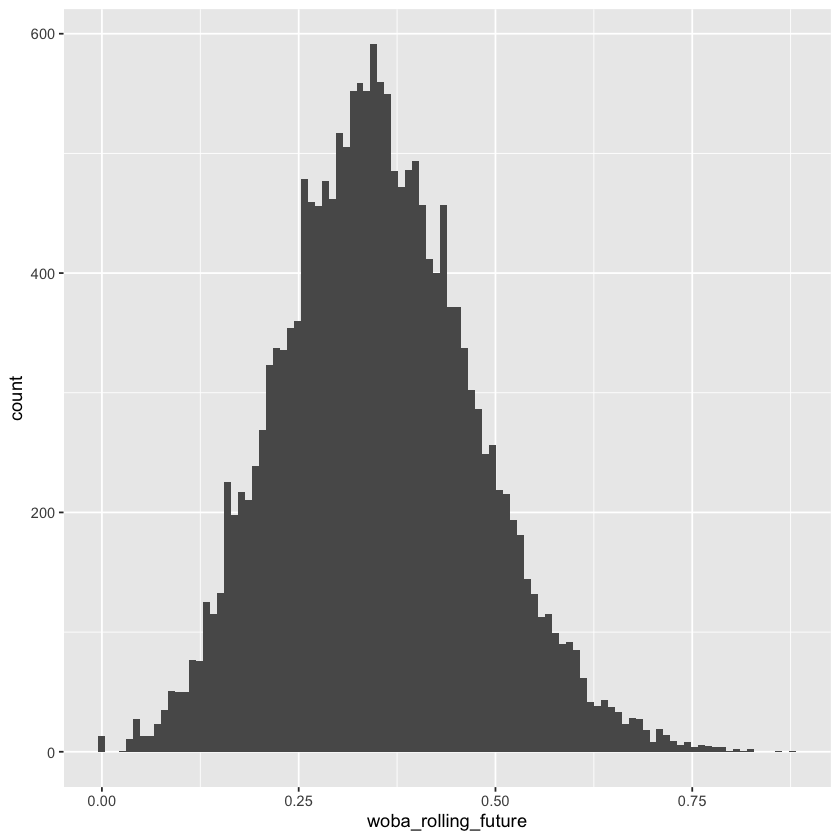

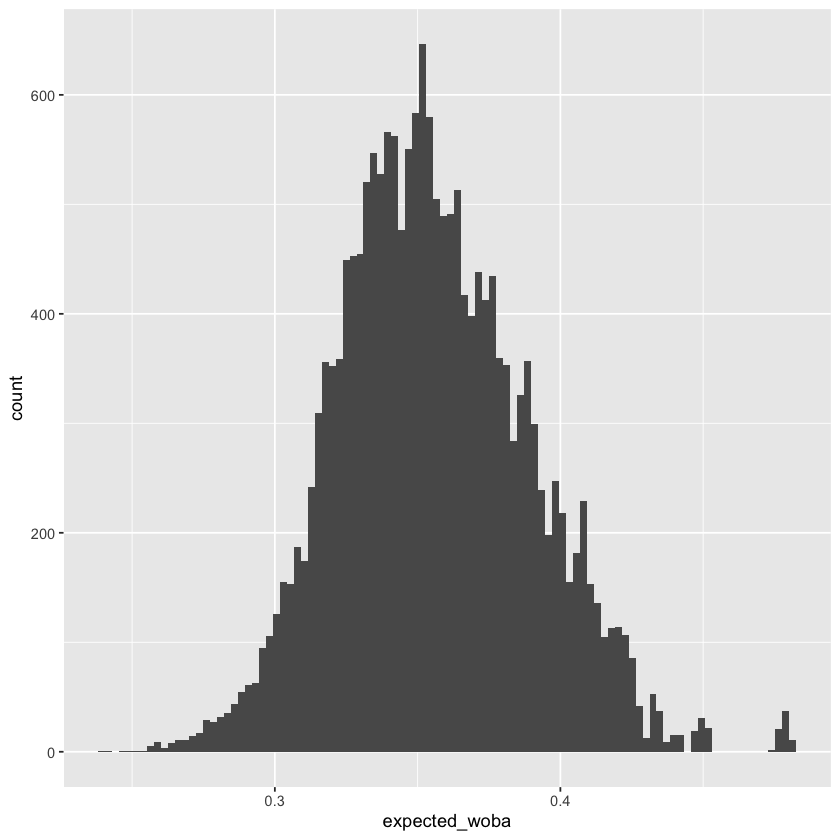

In [17]:
# inspect distributions of post-streak and expected woba
df %>% filter(is_hot==1) %>%
select(game.date, person.key, woba_rolling, 
       woba_rolling_future, expected_woba, 
       pa_rolling, pa_rolling_future,
      ) %>% 
select(woba_rolling_future) %>% ggplot(aes(x=woba_rolling_future)) + geom_histogram(bins=100)

df %>% filter(is_hot==1) %>%
select(game.date, person.key, woba_rolling, 
       woba_rolling_future, expected_woba, 
       pa_rolling, pa_rolling_future,
      ) %>% 
select(expected_woba) %>% ggplot(aes(x=expected_woba)) + geom_histogram(bins=100)

## Repeat the above steps for 7-game streaks

In [18]:
# take rolling sums of woba components to get a 5g woba
library(zoo)
num_games_streak = 7
num_games_post_streak = 3
min_pa_in_streak = 4 * num_games_streak #4
min_pa_post_streak = 3 * num_games_post_streak #0
# different offset used for post streak folling counts for 3 vs. 5 game configuration. paste this in if changing streak lenghts.
seven_game_post = list(c(1, 2, 3, 4, 5, 6, 7)) #list(c(1, 2, 3))
five_game_post = list(c(1, 2, 3, 4, 5))

# this is ugly indentation but makes it harder to forget to paste something when updating it
df = df %>%
         arrange(season, person.key, game.date, game.key) %>%
         group_by(season, person.key) %>%
         mutate(woba_num_rolling =   roll_sum(woba_numerator, num_games_streak, align = "right", fill = NA),
                pa_rolling =         roll_sum(B_PA, num_games_streak, align = "right", fill = NA),
                woba_denom_rolling = roll_sum(woba_denominator, num_games_streak, align = "right", fill = NA),
                woba_rolling = woba_num_rolling/woba_denom_rolling,
                woba_num_rolling_future =   rollapply(woba_numerator, FUN=sum, seven_game_post, align = "left", fill = NA),
                pa_rolling_future =         rollapply(B_PA, FUN=sum, seven_game_post, align = "left", fill = NA),
                woba_denom_rolling_future = rollapply(woba_denominator, FUN=sum,  seven_game_post, align = "left", fill = NA),
                woba_rolling_future = woba_num_rolling_future/woba_denom_rolling_future,
                
                woba_num_rolling_future_nextgame =   rollapply(woba_numerator, FUN=sum, list(c(1)), align = "left", fill = NA),
                woba_denom_rolling_future_nextgame  = rollapply(woba_denominator, FUN=sum,  list(c(1)), align = "left", fill = NA),
                woba_rolling_future_nextgame  = woba_num_rolling_future_nextgame /woba_denom_rolling_future_nextgame 
        ) 

In [19]:
# get seasons' quantiles for woba thresholds
df %>% 
    # only consider periods with at least 20 pa in them 
    filter(pa_rolling >= min_pa_in_streak, pa_rolling_future >= min_pa_post_streak) %>% 
    group_by(season, person.key, game.key) %>% summarise(woba = sum(woba_numerator) / sum(woba_denominator),
                                                  #woba_rolling_avg = mean(woba_rolling, na.rm=TRUE), 
                                                  woba_rolling_avg = sum(woba_num_rolling, na.rm=TRUE)/sum(woba_denom_rolling, na.rm=TRUE),
                                                  pa = sum(B_PA)) %>%
    ungroup() %>%
    #group_by(season) %>%
    summarise(thresholds = quantile(woba_rolling_avg, probs = c(0.05, 0.95), na.rm=TRUE)) 

`summarise()` regrouping output by 'season', 'person.key' (override with `.groups` argument)



thresholds
<dbl>
0.1913793
0.5143750


In [20]:
# create is hot/cold flags
hot_threshold = .514
cold_threshold = .191
df = df %>% ungroup() %>% 
    mutate(is_hot = ifelse(((woba_rolling > hot_threshold) & (pa_rolling>=min_pa_in_streak) & (game_num < 157)), 1, 0),
           is_cold = ifelse(((woba_rolling < cold_threshold) & (pa_rolling>=min_pa_in_streak) & (game_num < 157)), 1, 0))

In [21]:
df %>% ungroup() %>%
    filter(is_hot==1,
          !is.na(woba_rolling_future)) %>%
    summarise(
        unique_hot_players = n_distinct(person.key),
        total_hot_streaks = sum(is_hot),
        total_hot_pa = sum(pa_rolling),
        mean_hot_woba = sum(woba_num_rolling, na.rm=TRUE)/sum(woba_denom_rolling, na.rm=TRUE),
        mean_post_hot_woba = sum(woba_num_rolling_future, na.rm=TRUE)/sum(woba_denom_rolling_future, na.rm=TRUE),
        mean_post_hot_woba_nextgame = sum(woba_num_rolling_future_nextgame, na.rm=TRUE)/sum(woba_denom_rolling_future_nextgame, na.rm=TRUE),
        std_mean_post_hot_woba = 1.96 * (sd(woba_num_rolling_future/woba_denom_rolling_future, na.rm=TRUE) / sqrt(n())),
        upper_ci_post = mean_post_hot_woba + std_mean_post_hot_woba,
        lower_ci_post = mean_post_hot_woba - std_mean_post_hot_woba,
        expected_woba= mean(expected_woba, na.rm=TRUE)
    )

df %>% ungroup() %>%
    filter(is_cold==1,
          !is.na(woba_rolling_future)) %>%
    #group_by(season) %>%
    summarise(
        unique_hot_players = n_distinct(person.key),
        total_hot_streaks = sum(is_cold),
        total_hot_pa = sum(pa_rolling),
        mean_hot_woba = sum(woba_num_rolling, na.rm=TRUE)/sum(woba_denom_rolling, na.rm=TRUE),
        mean_post_hot_woba = sum(woba_num_rolling_future, na.rm=TRUE)/sum(woba_denom_rolling_future, na.rm=TRUE),
        mean_post_hot_woba_nextgame = sum(woba_num_rolling_future_nextgame, na.rm=TRUE)/sum(woba_denom_rolling_future_nextgame, na.rm=TRUE),
        std_mean_post_hot_woba = 1.96 * (sd(woba_num_rolling_future/woba_denom_rolling_future, na.rm=TRUE) / sqrt(n())),
        upper_ci_post = mean_post_hot_woba + std_mean_post_hot_woba,
        lower_ci_post = mean_post_hot_woba - std_mean_post_hot_woba,
        expected_woba= mean(expected_woba, na.rm=TRUE)
    )

unique_hot_players,total_hot_streaks,total_hot_pa,mean_hot_woba,mean_post_hot_woba,mean_post_hot_woba_nextgame,std_mean_post_hot_woba,upper_ci_post,lower_ci_post,expected_woba
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
848,17799,547535,0.5627349,0.3593182,0.3576631,0.001524393,0.3608426,0.3577938,0.3594971


unique_hot_players,total_hot_streaks,total_hot_pa,mean_hot_woba,mean_post_hot_woba,mean_post_hot_woba_nextgame,std_mean_post_hot_woba,upper_ci_post,lower_ci_post,expected_woba
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1028,17401,520219,0.1580786,0.3252085,0.3238884,0.001507746,0.3267162,0.3237007,0.3239573
